# Day 2: Support Vector Regression (SVR) for Price Prediction

## 🎯 Learning Objectives
- Understand Support Vector Machines for regression
- Learn about kernel methods and the kernel trick
- Implement SVR for non-linear price prediction
- Compare linear vs RBF vs polynomial kernels

---

## 📚 Theory: Support Vector Regression

### From Classification to Regression
SVR adapts the SVM classification idea to regression by introducing an **ε-insensitive tube**.

### The SVR Objective
Minimize:
$$\frac{1}{2}||w||^2 + C\sum_{i=1}^{n}(\xi_i + \xi_i^*)$$

Subject to:
$$y_i - w^T\phi(x_i) - b \leq \epsilon + \xi_i$$
$$w^T\phi(x_i) + b - y_i \leq \epsilon + \xi_i^*$$

### Key Parameters
- **C (Regularization)**: Trade-off between flatness and error tolerance
- **ε (Epsilon)**: Width of the tube (no penalty inside)
- **γ (Gamma)**: Kernel coefficient (RBF kernel)

### The Kernel Trick
Maps data to higher dimensions without explicit computation:
$$K(x_i, x_j) = \phi(x_i)^T \phi(x_j)$$

**Common Kernels:**
- Linear: $K(x, y) = x^T y$
- RBF: $K(x, y) = exp(-\gamma ||x-y||^2)$
- Polynomial: $K(x, y) = (\gamma x^T y + r)^d$

### Finance Applications
1. **Return Prediction**: Non-linear relationships
2. **Volatility Forecasting**: Complex patterns
3. **Factor Returns**: Non-linear factor exposure

### Pros and Cons

| Pros | Cons |
|------|------|
| Handles non-linear relationships | Slow for large datasets |
| Robust to outliers (ε-tube) | Many hyperparameters |
| Kernel flexibility | Hard to interpret |
| Global optimum guaranteed | Memory intensive |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252

# Download data
tickers = ['SPY', 'AAPL', 'MSFT', 'GOOGL', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data loaded: {len(prices)} days")

📥 Downloading data...
✅ Data loaded: 1254 days


In [2]:
# Feature engineering for SVR
spy = prices['SPY'].copy()
spy_returns = returns['SPY'].copy()

features = pd.DataFrame(index=spy.index)

# Lag features
for lag in [1, 2, 3, 5, 10]:
    features[f'return_lag{lag}'] = spy_returns.shift(lag)

# Rolling statistics
features['vol_5d'] = spy_returns.rolling(5).std() * np.sqrt(TRADING_DAYS)
features['vol_20d'] = spy_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
features['momentum_5d'] = spy_returns.rolling(5).sum()
features['momentum_20d'] = spy_returns.rolling(20).sum()

# Technical indicators
features['ma_ratio'] = spy / spy.rolling(20).mean()
features['bb_upper'] = (spy - spy.rolling(20).mean()) / (spy.rolling(20).std() * 2)

# Target: Next 5-day return
features['target'] = spy_returns.rolling(5).sum().shift(-5)

features = features.dropna()
print(f"\n📊 Features: {features.shape[1]-1} features, {len(features)} samples")


📊 Features: 11 features, 1229 samples


In [3]:
# Prepare data
feature_cols = [c for c in features.columns if c != 'target']
X = features[feature_cols]
y = features['target']

# Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X_scaled.iloc[:train_size], X_scaled.iloc[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
y_test_orig = y.iloc[train_size:]

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")

Training: 983 | Testing: 246


In [4]:
# Compare different kernels
kernels = {
    'Linear': SVR(kernel='linear', C=1.0),
    'RBF': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'Polynomial': SVR(kernel='poly', C=1.0, degree=2, gamma='scale')
}

results = []
predictions = {}

for name, model in kernels.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    predictions[name] = y_pred_orig
    
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    
    results.append({'Kernel': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SVR KERNEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))


SVR KERNEL COMPARISON
    Kernel     RMSE      MAE        R²
    Linear 0.023021 0.015805  0.025283
       RBF 0.024162 0.016277 -0.073790
Polynomial 0.028255 0.017907 -0.468422


In [5]:
# Hyperparameter tuning for best kernel (RBF)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.2]
}

tscv = TimeSeriesSplit(n_splits=3)
svr = SVR(kernel='rbf')

grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\n🎯 Best Parameters: {grid_search.best_params_}")
print(f"   Best CV Score: {-grid_search.best_score_:.6f}")


🎯 Best Parameters: {'C': 0.1, 'epsilon': 0.2, 'gamma': 0.01}
   Best CV Score: 1.111294


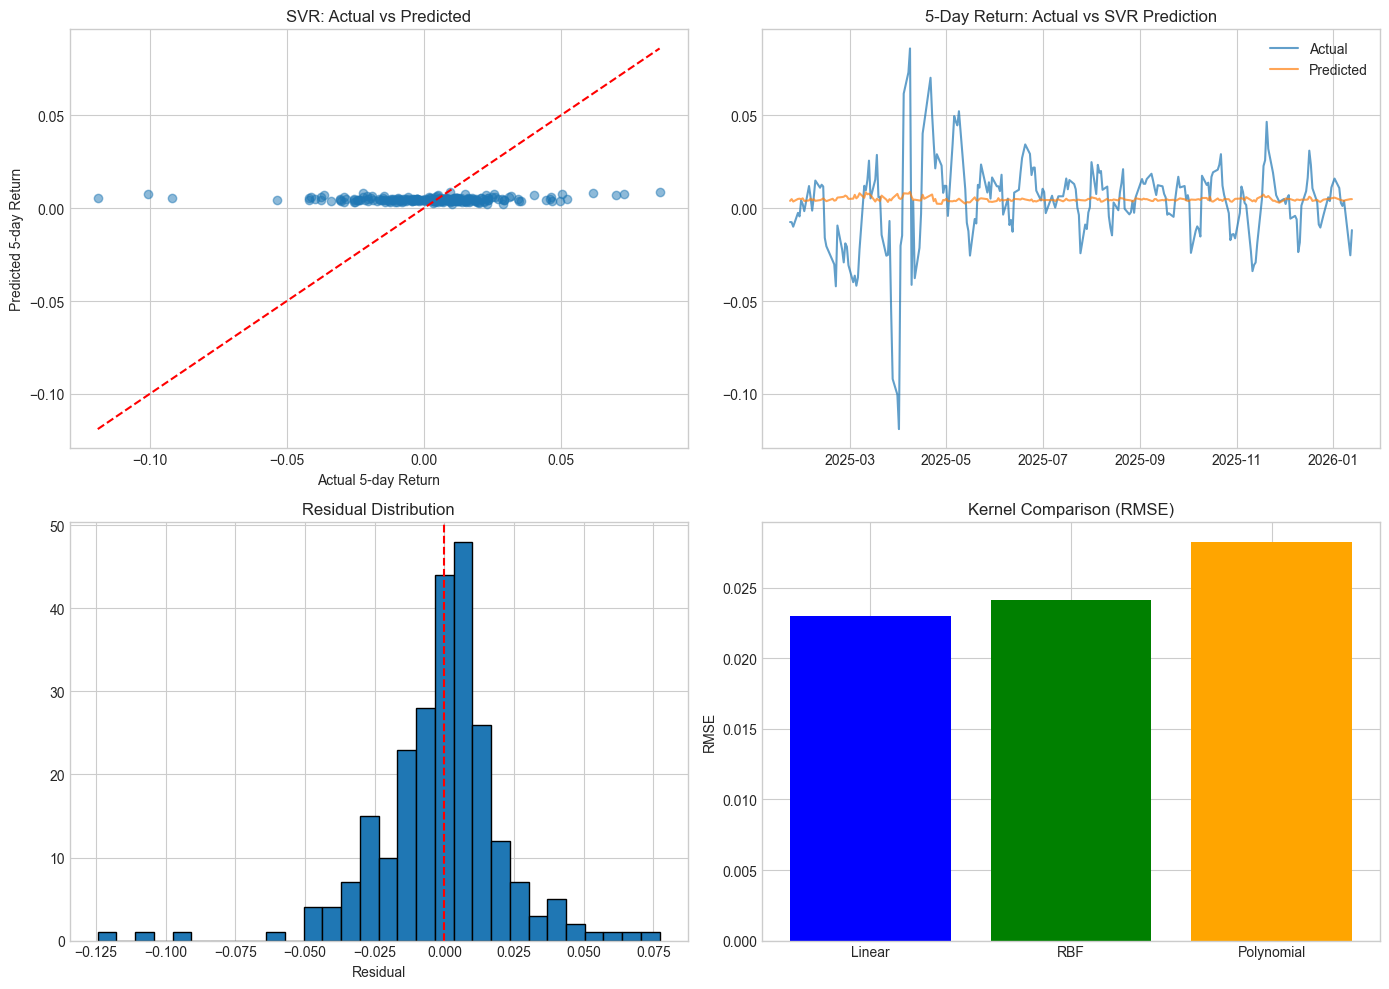

In [6]:
# Final model with best params
best_svr = grid_search.best_estimator_
y_pred_best = best_svr.predict(X_test)
y_pred_best_orig = scaler_y.inverse_transform(y_pred_best.reshape(-1, 1)).flatten()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted
axes[0, 0].scatter(y_test_orig, y_pred_best_orig, alpha=0.5)
axes[0, 0].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
axes[0, 0].set_xlabel('Actual 5-day Return')
axes[0, 0].set_ylabel('Predicted 5-day Return')
axes[0, 0].set_title('SVR: Actual vs Predicted')

# Time series
axes[0, 1].plot(y_test_orig.index, y_test_orig.values, label='Actual', alpha=0.7)
axes[0, 1].plot(y_test_orig.index, y_pred_best_orig, label='Predicted', alpha=0.7)
axes[0, 1].set_title('5-Day Return: Actual vs SVR Prediction')
axes[0, 1].legend()

# Residuals
residuals = y_test_orig.values - y_pred_best_orig
axes[1, 0].hist(residuals, bins=30, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].set_title('Residual Distribution')
axes[1, 0].set_xlabel('Residual')

# Kernel comparison
x_pos = range(len(results_df))
axes[1, 1].bar(x_pos, results_df['RMSE'], color=['blue', 'green', 'orange'])
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(results_df['Kernel'])
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Kernel Comparison (RMSE)')

plt.tight_layout()
plt.show()

In [7]:
# Trading strategy based on SVR predictions
strategy = pd.DataFrame(index=y_test_orig.index)
strategy['actual_5d'] = y_test_orig
strategy['predicted_5d'] = y_pred_best_orig
strategy['signal'] = np.sign(strategy['predicted_5d'])  # Long if positive, short if negative
strategy['spy_return'] = returns['SPY'].loc[strategy.index]
strategy['strategy_return'] = strategy['signal'].shift(1) * strategy['spy_return']

# Cumulative returns
strategy['spy_cumulative'] = (1 + strategy['spy_return']).cumprod()
strategy['strategy_cumulative'] = (1 + strategy['strategy_return']).cumprod()

# Calculate metrics
def calc_metrics(rets, name):
    total = (1 + rets).prod() - 1
    ann_ret = (1 + total) ** (TRADING_DAYS / len(rets)) - 1
    ann_vol = rets.std() * np.sqrt(TRADING_DAYS)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    return {'Strategy': name, 'Return': f'{total:.2%}', 'Sharpe': f'{sharpe:.2f}'}

print("\n" + "="*60)
print("SVR TRADING STRATEGY RESULTS")
print("="*60)
metrics = [calc_metrics(strategy['spy_return'].dropna(), 'Buy & Hold'),
           calc_metrics(strategy['strategy_return'].dropna(), 'SVR Strategy')]
print(pd.DataFrame(metrics).to_string(index=False))


SVR TRADING STRATEGY RESULTS
    Strategy Return Sharpe
  Buy & Hold 16.39%   0.87
SVR Strategy 15.74%   0.84


In [8]:
# Next day prediction
latest_X = X_scaled.iloc[-1:]
pred_scaled = best_svr.predict(latest_X)
pred_return = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))[0, 0]

print("\n" + "="*60)
print("📊 5-DAY RETURN PREDICTION")
print("="*60)
print(f"\nModel: SVR with {grid_search.best_params_}")
print(f"\n🎯 Predicted 5-Day Return: {pred_return:+.2%}")
print(f"   Signal: {'LONG ↑' if pred_return > 0 else 'SHORT ↓'}")
print(f"   Model R²: {r2_score(y_test_orig, y_pred_best_orig):.4f}")


📊 5-DAY RETURN PREDICTION

Model: SVR with {'C': 0.1, 'epsilon': 0.2, 'gamma': 0.01}

🎯 Predicted 5-Day Return: +0.48%
   Signal: LONG ↑
   Model R²: 0.0018


## 🏢 Real-World Usage

| Firm | SVR Application |
|------|----------------|
| Goldman Sachs | Non-linear factor models |
| Citadel | Options pricing with regime changes |
| DE Shaw | Alternative data signal extraction |

### Interview Tips
1. **Why SVR over linear regression?** - Captures non-linear patterns, robust to outliers
2. **What does ε control?** - Width of tube where errors aren't penalized
3. **RBF vs Linear kernel?** - RBF for complex non-linear, Linear for interpretability

---
## 📅 Tomorrow: Kernel Methods Deep Dive